In [2]:
%matplotlib inline
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import math
#import cv2
from skimage import measure
#from skimage.metrics import structural_similarity as ssim

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    #np.clip(newgray, 0, 1) # quando faço isso ela deixa de ser normal!!!
    return newgray

In [4]:
### Base de dados

db = fetch_lfw_people()

faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Adicionando ruído de sd = 0.05
del faces
faces = faces_matrix
noisyfaces = add_noise(0.05, faces)

In [5]:
### Selecionando uma imagem
im1 = faces[123] # pele negra
im2 = faces[127] # pele branca

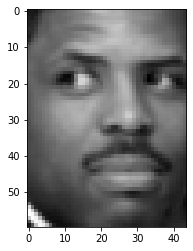

In [6]:
plt.imshow(im1, cmap = 'gray')

In [7]:
# Outra imagem: um retrato

im3 = imread("autumn-goodman-vTL_qy03D1I-unsplash.jpg")
im3.shape 

(3648, 5472, 3)

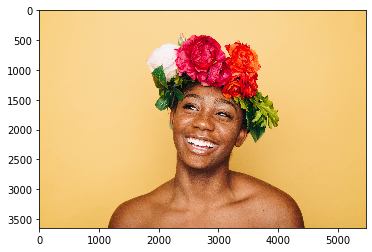

In [8]:
plt.imshow(im3)

Passando para preto e branco com uma função:

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

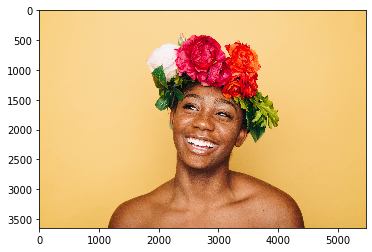

In [11]:
im3_gray = rgb2gray(im3)    
plt.imshow(im3, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

In [12]:
# normalizado
im3_gray = im3_gray/np.amax(im3_gray)

## Adicionando ruído

In [13]:
im1_noisy = add_noise(0.05, im1)
im2_noisy = add_noise(0.05, im2)
im3_noisy = add_noise(0.05, im3_gray)

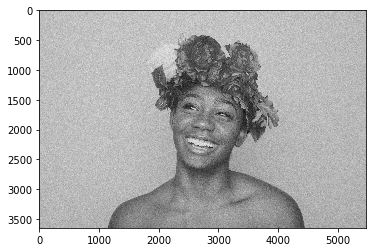

In [14]:
plt.imshow(add_noise(0.05, im3_gray), cmap=plt.get_cmap('gray'))

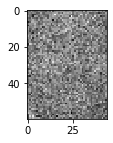

In [58]:
plt.figure(figsize = (20,2))
plt.imshow(add_noise(0.45, im1), cmap=plt.get_cmap('gray'))

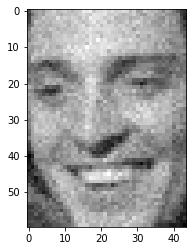

In [16]:
plt.imshow(add_noise(0.05, im2), cmap=plt.get_cmap('gray'))

# PSNR

#### Calculando PSNR

In [25]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return np.inf
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [26]:
psnr(im1, im1_noisy)

25.855139203568157

Variação do PNSR de acordo com a variância do ruído adicionado:

In [27]:
K = 20
sigma_seq = np.array(np.linspace(0.1, 3, K))

In [28]:
len(sigma_seq)

20

In [35]:
K = 20
sigma_seq = np.array(np.linspace(0.1, 3, K))
imagem_original = im1
psnr_seq = np.zeros(len(sigma_seq))
mse_seq = np.zeros(len(sigma_seq))

for i in range(len(sigma_seq)):
    x = add_noise(sigma_seq[i], imagem_original)
    psnr_seq[i] = psnr(imagem_original, x)
    mse_seq[i] = np.mean((imagem_original - x)**2)

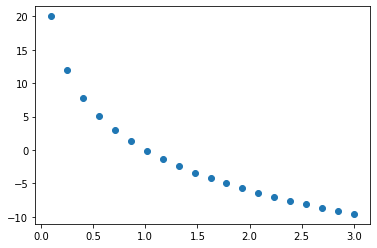

In [36]:
plt.scatter(sigma_seq, psnr_seq)

a **higher** PSNR generally indicates that the reconstruction is of **higher quality**

Usando só SNR, temos: A ratio higher than 1:1 (greater than 0 dB) indicates more signal than noise. 

# MSE

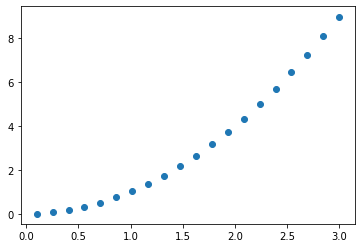

In [37]:
plt.scatter(sigma_seq, mse_seq)

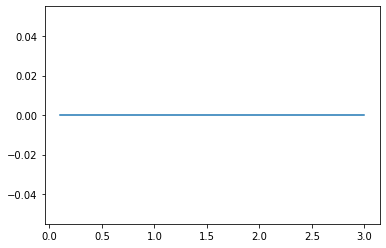

In [33]:
plt.plot(sigma_seq, np.sqrt(mse_seq))

Eu usaria simplesmente o MSE para medir o erro nesse caso, o PSNR tá meio estranho, parece carteado, e é inversamente proporcional à variância da normal.

Aliás, o MSE não é o EMV pra esse caso?? (SE EU NÃO USAR O CLIP, CLARO!)

# SSIM

Estou cheia de formas de calcular o SSIM...
measure.compare_ssim que é igual a skimage.metric.structural_similarity (foi deprecada),
e o tf.reduce_mean do tf.imagem.ssim


In [17]:
measure.compare_ssim(im1, im1_noisy)

0.8138605633852475

In [52]:
K = 1000
sigma_seq = np.array(np.linspace(0.00001, 0.5, K))

imagem_original = im1
ssim_seq = np.zeros(len(sigma_seq))

for i in range(len(sigma_seq)):
    x = add_noise(sigma_seq[i], imagem_original)
    ssim_seq[i] = measure.compare_ssim(imagem_original, x)

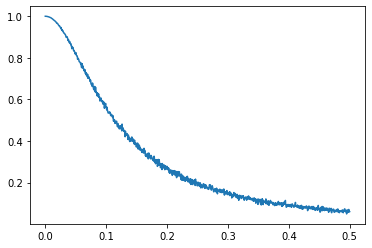

In [53]:
plt.plot(sigma_seq, ssim_seq)

In [40]:
ssim_seq

array([0.99999999, 0.99997471, 0.99990264, ..., 0.01638101, 0.01409185,
       0.01833574])

In [ ]:
skimage.metrics.structural_similarity(im, im1_noisy, full = True)

In [42]:
def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))